In [2]:
import pandas as pd
import emoji, string
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv('DataSet.csv')
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

df.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mervseah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(17880, 18)

## 1. Exploratory Data Analysis

## 2. Data Cleaning

In [3]:
df.drop_duplicates(subset=['title','location', 'department' , 'salary_range', 'company_profile', 'description', 'requirements', 'benefits','telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent'], keep='first', inplace=True)
df.shape

(17632, 18)

## 3. Feature Engineering

In [4]:
## TEXT PREPROCESSING FOR TEXTUAL COLUMNS

def clean_text_features(text):
    try:
        if pd.isnull(text):
            return ""
        
        # Remove HTML tags
        text = re.sub(r'<[^>]*>', '', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove non-alphanumeric characters (except specified punctuation)
        text = re.sub(r'[^\w\s.,:;!?\'"-]', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove emojis
        text = emoji.replace_emoji(text, replace="")
        
        # Remove stopwords
        stop_words = set(stopwords.words("english"))
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        text = " ".join(filtered_words)
        
        return text

    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""


text_columns = ['title', 'benefits', 'description', 'requirements', 'company_profile']

for col in text_columns:
    df[col] = df[col].apply(clean_text_features)

df['combined_text_data'] = (
    df['title'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['company_profile'] + ' ' +
    df['benefits']
)


In [6]:
## encoding categorical columns

categorical_columns = ['location', 'department', 'employment_type', 'required_experience', 
                       'required_education', 'industry', 'function']

encoders = {} ## storing this here first if we wanna use them later

for column in categorical_columns:

        le = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  
        encoders[column] = le
        
        df[column] = df[column].fillna('Unknown') 
        
        encoded_values = le.fit_transform(df[[column]])  
        
        encoded_df = pd.DataFrame(
            encoded_values, 
            columns=[f"{column}_{cat}" for cat in le.categories_[0]],
            index=df.index
        )
        
        df = pd.concat([df, encoded_df], axis=1)

In [7]:
## encodign binary columns

'''
important: idk if we should keep in_balanced_dataset
'''
binary_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent', 'in_balanced_dataset']

for column in binary_columns:
    if column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else None))

In [8]:
## numerical columns
df[['salary_lower', 'salary_upper']] = df['salary_range'].str.split('-', expand=True).astype(float)
df['salary_average'] = (df['salary_lower'] + df['salary_upper']) / 2
df['salary_range_diff'] = df['salary_upper'] - df['salary_lower']


In [9]:
# DROPPING RAW TEXTUAL COLUMNS THAT ARE UNUSED

columns_to_drop = ['title', 'description', 'requirements', 'company_profile', 'benefits', 'salary_range', 'location', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
df.drop(columns_to_drop, axis = 1, inplace = True)

## 4a. Train Validation Test Split (Text and Categorical)
Train-Test-Validation: 70-15-15

In [10]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']  # Target variable to predict

## splitting into training (70%) and remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size = 0.15 / 0.85, random_state=42)

columns_to_normalize = ['salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
scaler = StandardScaler()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])

X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])

for dataset in [X_train, X_val, X_test]:
    display(dataset.shape)

(12342, 4650)

(934, 4650)

(4356, 4650)

## 4b. Train Validation Test Split (No Combined Cleaned Text)


In [11]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']

columns_to_drop2 = ['combined_text_data', 'salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
X_cat = X.drop(columns_to_drop2, axis = 1)

## splitting into training (70%) and remaining (30%)
X_train_cat, X_rem_cat, y_train_cat, y_rem_cat = train_test_split(X_cat, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test_cat, X_val_cat, y_test_cat, y_val_cat = train_test_split(X_rem_cat, y_rem_cat, test_size = 0.15 / 0.85, random_state=42)

for dataset in [X_train_cat, X_val_cat, X_test_cat]:
    display(dataset.shape)

(12342, 4645)

(934, 4645)

(4356, 4645)

## 5. Embeddings for textual data

In [12]:
#Count Vectorizer Embedding 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train['combined_text_data'])
X_train_count =  count_vect.transform(X_train['combined_text_data'])
X_val_count = count_vect.transform(X_val['combined_text_data'])
X_test_count = count_vect.transform(X_test['combined_text_data'])

#TFIDF Embedding 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['combined_text_data'])
X_train_tfidf = tfidf_vect.transform(X_train['combined_text_data'])
X_val_tfidf = tfidf_vect.transform(X_val['combined_text_data'])
X_test_tfidf = tfidf_vect.transform(X_test['combined_text_data'])

In [13]:
display(X_train_count.shape)
display(X_val_count.shape)
display(X_test_count.shape)

(12342, 60186)

(934, 60186)

(4356, 60186)

In [14]:
display(X_train_tfidf.shape)
display(X_val_tfidf.shape)
display(X_test_tfidf.shape)

(12342, 60126)

(934, 60126)

(4356, 60126)

## 6. Machine Learning Models


### 6.1. Log Reg

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

model = LogisticRegression(max_iter= 3000)

#### 6.1.1. Categorical Only

In [16]:
# Fit the model to the training data
model.fit(X_train_cat, y_train)

# Evaluate on validation set (to minimize loss)
val_pred_proba = model.predict_proba(X_val_cat)[:, 1]
val_auc = roc_auc_score(y_val, val_pred_proba)
print(f"Validation AUC-ROC: {val_auc:.4f}")

# Final evaluation on test set
test_pred = model.predict(X_test_cat)
test_pred_proba = model.predict_proba(X_test_cat)[:, 1]

accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc:.4f}")

Validation AUC-ROC: 0.9341
Test Accuracy: 0.9789
Test Precision: 0.8716
Test Recall: 0.6386
Test F1 Score: 0.7371
Test AUC-ROC: 0.9530


#### 6.1.2. Count Vect

In [17]:
# Fit the model to the training data
model.fit(X_train_count, y_train)

# Evaluate on validation set (to minimize loss)
val_pred_proba = model.predict_proba(X_val_count)[:, 1]
val_auc = roc_auc_score(y_val, val_pred_proba)
print(f"Validation AUC-ROC: {val_auc:.4f}")

# Final evaluation on test set
test_pred = model.predict(X_test_count)
test_pred_proba = model.predict_proba(X_test_count)[:, 1]

accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc:.4f}")

Validation AUC-ROC: 0.9366
Test Accuracy: 0.9848
Test Precision: 0.9000
Test Recall: 0.7574
Test F1 Score: 0.8226
Test AUC-ROC: 0.9692


#### 6.1.3. TF-IDF

In [18]:
# Fit the model to the training data
model.fit(X_train_tfidf, y_train)

# Evaluate on validation set (to minimize loss)
val_pred_proba = model.predict_proba(X_val_tfidf)[:, 1]
val_auc = roc_auc_score(y_val, val_pred_proba)
print(f"Validation AUC-ROC: {val_auc:.4f}")

# Final evaluation on test set
test_pred = model.predict(X_test_tfidf)
test_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC-ROC: {auc:.4f}")

Validation AUC-ROC: 0.9274
Test Accuracy: 0.9720
Test Precision: 0.9762
Test Recall: 0.4059
Test F1 Score: 0.5734
Test AUC-ROC: 0.9695


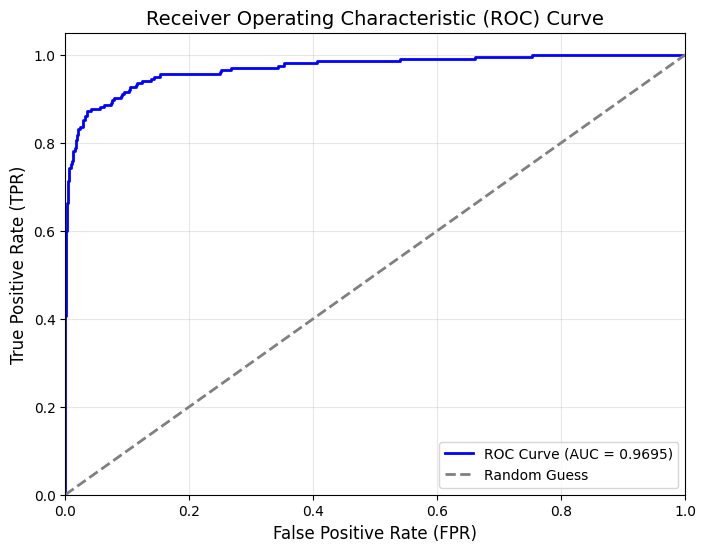

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### 6.2. Boosting Models

In [30]:
from scipy.sparse import hstack

binary_columns= ['telecommuting', 'has_company_logo', 'has_questions', 'in_balanced_dataset']
feature_columns = ['salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff'] + binary_columns

X_train_combined_count = hstack([X_train_count, X_train[feature_columns].values])
X_val_combined_count = hstack([X_val_count, X_val[feature_columns].values])
X_test_combined_count = hstack([X_test_count, X_test[feature_columns].values])

X_train_combined_tfidf = hstack([X_train_tfidf, X_train[feature_columns].values])
X_val_combined_tfidf = hstack([X_val_tfidf, X_val[feature_columns].values])
X_test_combined_tfidf = hstack([X_test_tfidf, X_test[feature_columns].values])


#### 6.2.1. XGBoost

In [31]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

## ===== COUNT VECTORISER =====

xgb_model_count = xgb.XGBClassifier(
    verbosity = 0,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_model_count.fit(X_train_combined_count, y_train)

xgb_pred_count = xgb_model_count.predict(X_test_combined_count)
xgb_auc_count = roc_auc_score(y_test, xgb_model_count.predict_proba(X_test_combined_count)[:, 1])
print(f"XGBoost AUC (CountVectorizer with binary columns): {xgb_auc_count:.4f}")

## ===== TFIDF =====

xgb_model_tfidf = xgb.XGBClassifier(
    verbosity = 0,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_model_tfidf.fit(X_train_combined_tfidf, y_train)

xgb_pred_tfidf = xgb_model_tfidf.predict(X_test_combined_tfidf)
xgb_auc_tfidf = roc_auc_score(y_test, xgb_model_tfidf.predict_proba(X_test_combined_tfidf)[:, 1])
print(f"XGBoost AUC (TFIDF with binary columns): {xgb_auc_tfidf:.4f}")

XGBoost AUC (CountVectorizer with binary columns): 0.9882
XGBoost AUC (TFIDF with binary columns): 0.9928


#### 6.2.2. LightBoost

In [29]:
import lightgbm as lgb

## ===== COUNT VECTORISER =====

lgb_model_count = lgb.LGBMClassifier(verbose=-1, random_state=42)
lgb_model_count.fit(X_train_combined_count, y_train)
lgb_pred_count = lgb_model_count.predict(X_test_combined_count)
lgb_auc_count = roc_auc_score(y_test, lgb_model_count.predict_proba(X_test_combined_count)[:, 1])
print(f"LightGBM AUC (CountVectoriser with binary columns): {lgb_auc_count:.4f}")

## ===== TFIDF =====

lgb_model_tfidf = lgb.LGBMClassifier(verbose=-1, random_state=42)
lgb_model_tfidf.fit(X_train_combined_tfidf, y_train)
lgb_pred_tfidf = lgb_model_tfidf.predict(X_test_combined_tfidf)
lgb_auc_tfidf = roc_auc_score(y_test, lgb_model_tfidf.predict_proba(X_test_combined_tfidf)[:, 1])
print(f"LightGBM AUC (TfidfVectorizer with binary columns): {lgb_auc_tfidf:.4f}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


LightGBM AUC (CountVectoriser with binary columns): 0.9901
LightGBM AUC (TfidfVectorizer with binary columns): 0.9901


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


#### 6.2.3. CatBoost

In [34]:
from catboost import CatBoostClassifier

X_train_combined_dense = X_train_combined_count.toarray()
X_val_combined_dense = X_val_combined_count.toarray()
X_test_combined_dense = X_test_combined_count.toarray()

cat_model = CatBoostClassifier(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    depth=6,                      # Depth of the tree
    loss_function='Logloss',      # Binary classification loss
    eval_metric='AUC',            # Evaluation metric
    random_seed=42,               # Seed for reproducibility
    verbose=100                   # Print training progress every 100 iterations
)

cat_model.fit(X_train_combined_dense, y_train, eval_set=(X_val_combined_dense, y_val), early_stopping_rounds=50)

test_pred_proba = cat_model.predict_proba(X_test_combined_dense)[:, 1]  # Probabilities for positive class
auc_score = roc_auc_score(y_test, test_pred_proba)
print(f"ROC-AUC: {auc_score:.4f}")

test_pred = cat_model.predict(X_test_combined_dense)
print(classification_report(y_test, test_pred))



0:	test: 0.5028058	best: 0.5028058 (0)	total: 141ms	remaining: 2m 20s
100:	test: 0.9815728	best: 0.9815728 (88)	total: 6.9s	remaining: 1m 1s
200:	test: 0.9882024	best: 0.9886201 (195)	total: 13.3s	remaining: 53s
300:	test: 0.9899251	best: 0.9899512 (293)	total: 19.7s	remaining: 45.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9900033931
bestIteration = 304

Shrink model to first 305 iterations.
ROC-AUC: 0.9870
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4154
           1       0.94      0.84      0.89       202

    accuracy                           0.99      4356
   macro avg       0.97      0.92      0.94      4356
weighted avg       0.99      0.99      0.99      4356

